In [1]:
import itertools
from pathlib import Path

import mne
import nltk
import numpy as np
import pandas as pd
import re
import scipy.io
from tqdm.notebook import tqdm

import sys
sys.path.append(Path(".").resolve())

DATA_DIR = Path("/om/data/public/broderick2018/Natural Speech")
EEG_DIR = DATA_DIR / "EEG"

EPOCH_WINDOW = (-0.2, 0.5)
TEST_WINDOW = (0.3, 0.5)
# Band-pass filter parameters
FILTER_WINDOW = (1., 8.)

In [2]:
%load_ext autoreload
%autoreload 2

In [6]:
from mfn400.adapters.broderick2018 import BroderickDatasetAdapter
from mfn400.n400 import prepare_n400_df

In [14]:
data = BroderickDatasetAdapter(EEG_DIR, Path("./out/stim_df.csv"))

In [25]:
epochs = data.to_erp(EPOCH_WINDOW, filter_window=FILTER_WINDOW)

Not setting metadata
Not setting metadata
5459 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 5459 events and 91 original time points ...
0 bad epochs dropped


In [26]:
n400_dfs = {subject: prepare_n400_df(epochs[subject],
                                     data.stimulus_df,
                                     TEST_WINDOW)
            for subject in epochs}

Applying baseline correction (mode: mean)


---

In [12]:
import seaborn as sns

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-_k1y_z8y because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


<AxesSubplot:xlabel='surprisal', ylabel='V1'>

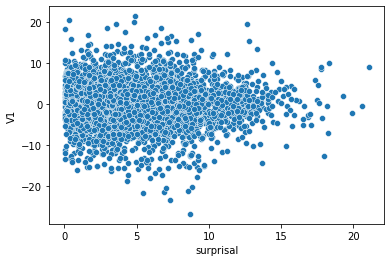

In [27]:
sns.scatterplot(data=n400_dfs["1"], x="surprisal", y="V1")

Reference: https://mne.tools/stable/auto_tutorials/evoked/30_eeg_erp.html#sphx-glr-auto-tutorials-evoked-30-eeg-erp-py

## TODO

- other preprocessing which might be necessary
  - ICA
  - eye movement artifact removal

## Glossary

- preprocessing steps
  - detrending: Subtract least-square linear fit from time series, cf. https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.detrend.html
  - baselining: Subtract per-channel mean from signal
  - decimating: Data subsampling (over time)
  
## Changes to match Frank et al. 2015

- N400 window: 300-500 ms
- drop sentence-final words
- no baselining. instead, include t=0 potential as a control predictor in mixef model
- mixed effects model
    - control predictors
        - log word frequency
        - word length
        - word position in sentence
        - sentence position
- modulus transformation

In [ ]:
# def run(idx, *args, **kwargs):
#     print("==========", idx)
#     return utils.run_n400(*args, **kwargs)
# n400_dfs = {subject: run(subject, paths, data_channels, reference_channels,
#                          sample_rate=SAMPLE_RATE,
#                          stim_df=stim_df,
#                          filter_low=FILTER_LOW, filter_high=FILTER_HIGH,
#                          epoch_window=EPOCH_WINDOW,
#                          test_window=TEST_WINDOW)
#             for subject, paths in tqdm(list(eeg_paths.items()))}

In [28]:
n400_df = pd.concat(n400_dfs, names=["subject"])

In [20]:
# n400_df.to_csv("broderick_naturalistic_n400.csv")

### Demo with one subject

In [21]:
# Dummy corr check: correlation between word length and 400ms baselined response

id_vars = ["subject", "word", "surprisal", "epoch", "item"]
electrode_corrs = n400_df.reset_index()[id_vars + data.data_channels] \
    .melt(id_vars=id_vars, var_name="electrode") \
    .dropna() \
    .groupby(["subject", "electrode"]).apply(lambda xs: np.corrcoef(xs.surprisal, xs.value)[0, 1])
electrode_corrs.sort_values().head(20)

subject  electrode
1        V48         -0.006013
         V36         -0.004983
         V50         -0.003232
         V3          -0.002707
         V35         -0.002409
         V72         -0.001573
         V112        -0.000892
         V34         -0.000067
         V49          0.000235
         V125         0.000402
         V80          0.000801
         V51          0.001496
         V79          0.001521
         V93          0.001631
         V21          0.001749
         V92          0.001925
         V91          0.002010
         V94          0.002103
         V81          0.002679
         V47          0.003072
dtype: float64

In [22]:
electrode_corrs.sort_values().tail(20)

subject  electrode
1        V11          0.022075
         V119         0.022663
         V108         0.023226
         V42          0.023566
         V106         0.023978
         V107         0.024081
         V18          0.024383
         V128         0.025543
         V116         0.025946
         V117         0.026234
         V122         0.026318
         V10          0.026814
         V5           0.027421
         V115         0.027462
         V9           0.028301
         V127         0.029218
         V114         0.029521
         V123         0.035326
         V105         0.035479
         V126         0.036035
dtype: float64

<AxesSubplot:ylabel='Frequency'>

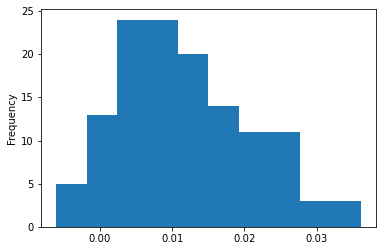

In [23]:
electrode_corrs.plot.hist()